In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

2020-10-31 11:28:46,461 - INFO - icrawler.crawler - start crawling...
2020-10-31 11:28:46,467 - INFO - icrawler.crawler - starting 1 feeder threads...
2020-10-31 11:28:46,468 - INFO - feeder - thread feeder-001 exit
2020-10-31 11:28:46,470 - INFO - icrawler.crawler - starting 1 parser threads...
2020-10-31 11:28:46,473 - INFO - icrawler.crawler - starting 1 downloader threads...
2020-10-31 11:28:46,779 - INFO - parser - parsing result page https://www.bing.com/images/async?q=猫&first=0
2020-10-31 11:28:46,797 - INFO - downloader - skip downloading file 000001.jpg
2020-10-31 11:28:46,798 - INFO - downloader - skip downloading file 000002.jpg
2020-10-31 11:28:46,799 - INFO - downloader - skip downloading file 000003.jpg
2020-10-31 11:28:46,800 - INFO - downloader - skip downloading file 000004.jpg
2020-10-31 11:28:46,801 - INFO - downloader - skip downloading file 000005.jpg
2020-10-31 11:28:46,803 - INFO - downloader - skip downloading file 000006.jpg
2020-10-31 11:28:46,803 - INFO - dow

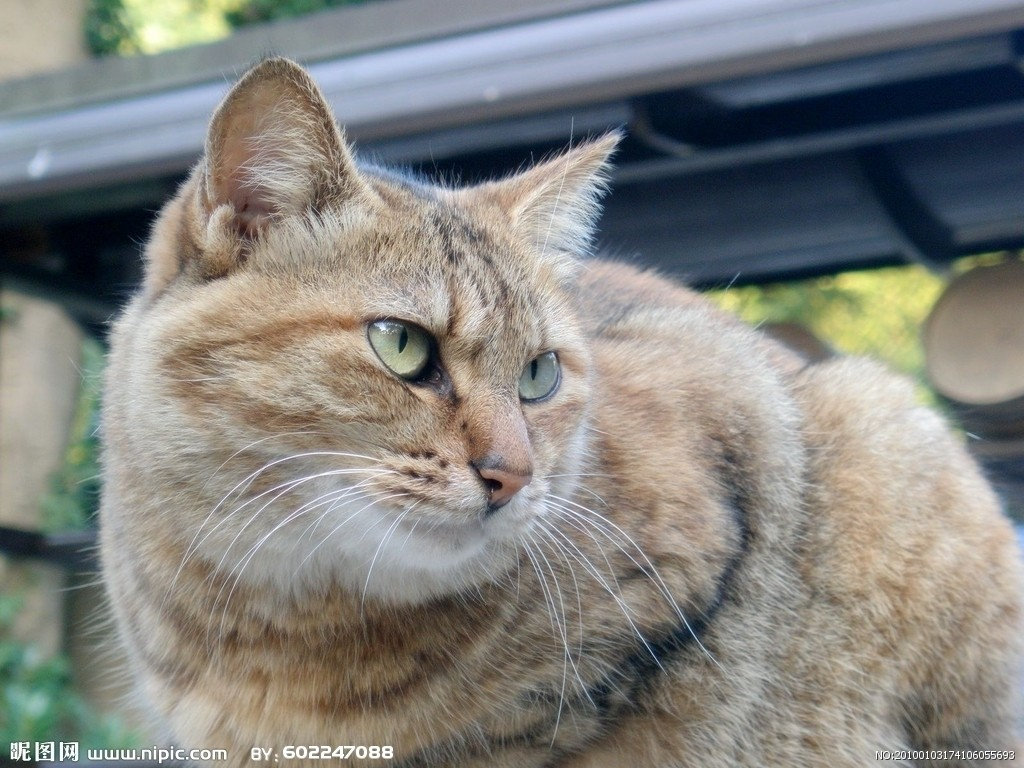

Epoch 1/40
75/75 [==============================] - 1s 13ms/step - loss: 0.6739 - accuracy: 0.5803
Epoch 2/40
75/75 [==============================] - 1s 12ms/step - loss: 0.6032 - accuracy: 0.6822
Epoch 3/40
75/75 [==============================] - 1s 12ms/step - loss: 0.5555 - accuracy: 0.7202
Epoch 4/40
75/75 [==============================] - 1s 12ms/step - loss: 0.5057 - accuracy: 0.7635
Epoch 5/40
75/75 [==============================] - 1s 12ms/step - loss: 0.4487 - accuracy: 0.8034
Epoch 6/40
75/75 [==============================] - 1s 12ms/step - loss: 0.4095 - accuracy: 0.8091
Epoch 7/40
75/75 [==============================] - 1s 12ms/step - loss: 0.3645 - accuracy: 0.8356
Epoch 8/40
75/75 [==============================] - 1s 12ms/step - loss: 0.3270 - accuracy: 0.8654
Epoch 9/40
75/75 [==============================] - 1s 12ms/step - loss: 0.2970 - accuracy: 0.8760
Epoch 10/40
75/75 [==============================] - 1s 12ms/step - loss: 0.2582 - accuracy: 0.8986
Epoch 11/

In [10]:
!pip install icrawler


from icrawler.builtin import BingImageCrawler

# 猫の画像を100枚取得
# iCrawler(画像検索あぷり)のなかで猫と検索
# 100枚あつめた
crawler = BingImageCrawler(storage={"root_dir": "cat"})
crawler.crawl(keyword="猫", max_num=100)

from icrawler.builtin import BingImageCrawler

# 犬の画像を100枚取得
crawler = BingImageCrawler(storage={"root_dir": "dog"})
crawler.crawl(keyword="犬", max_num=100)


from PIL import Image
import os, glob
import numpy as np
from PIL import ImageFile
# IOError: image file is truncated (0 bytes not processed)回避のため
ImageFile.LOAD_TRUNCATED_IMAGES = True

classes = ["dog", "cat"]
num_classes = len(classes)
image_size = 64
num_testdata = 25
#トレーニング、テストデータセット
X_train = []
X_test  = []
y_train = []
y_test  = []

#enumerateでインデックスとリストを同時に取得できる
for index, classlabel in enumerate(classes):
    photos_dir = "./" + classlabel
    #特定のデータ(今回は写真)に絞り込む
    files = glob.glob(photos_dir + "/*.jpg")
    for i, file in enumerate(files):
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        if i < num_testdata:
          #テストデータセットにデータとindexをいれてる
            X_test.append(data)
            y_test.append(index)
        else:

            # angleに代入される値
            # -20
            # -15
            # -10
            #  -5
            # 0
            # 5
            # 10
            # 15
            for angle in range(-20, 20, 5):

                img_r = image.rotate(angle)
                data = np.asarray(img_r)
                X_train.append(data)
                y_train.append(index)
                # FLIP_LEFT_RIGHT　は 左右反転
                img_trains = img_r.transpose(Image.FLIP_LEFT_RIGHT)
                data = np.asarray(img_trains)
                X_train.append(data)
                y_train.append(index)

#トレーニングセットをnumpyリストに変更
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

xy = (X_train, X_test, y_train, y_test)
#dos_cat.npyというファイル名で保存、データセット完成
np.save("./dog_cat.npy", xy)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import RMSprop
from keras.utils import np_utils
import keras
import numpy as np

classes = ["dog", "cat"]
num_classes = len(classes)
image_size = 64

"""
データを読み込む関数
"""
def load_data():
    # データセットをdog_cat.npyに読み込む
    X_train, X_test, y_train, y_test = np.load("./dog_cat.npy", allow_pickle=True)
    # 入力データの各画素値を0-1の範囲で正規化(学習コストを下げるため)
    X_train = X_train.astype("float") / 255
    X_test  = X_test.astype("float") / 255
    # to_categorical()にてラベルをone hot vector化
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test  = np_utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_test, y_test

"""
モデルを学習する関数
"""
def train(X, y, X_test, y_test):
    model = Sequential()

    # Xは(1200, 64, 64, 3)
    # X.shape[1:]とすることで、(64, 64, 3)となり、入力にすることが可能です。
    model.add(Conv2D(32,(3,3), padding='same',input_shape=X.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))

    model.add(Conv2D(64,(3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.45))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # https://keras.io/ja/optimizers/
    # 今回は、最適化アルゴリズムにRMSpropを利用
    opt = RMSprop(lr=0.00005, decay=1e-6)
    # https://keras.io/ja/models/sequential/
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
    model.fit(X, y, batch_size=28, epochs=40)
    # HDF5ファイルにKerasのモデルを保存
    model.save('./cnn.h5')

    return model

"""
メイン関数
データの読み込みとモデルの学習を行います。
"""
def main():
    # データの読み込み
    X_train, y_train, X_test, y_test = load_data()

    # モデルの学習
    model = train(X_train, y_train, X_test, y_test)

main()

import keras
import sys, os
import numpy as np
from keras.models import load_model

imsize = (64, 64)

"""
animal.jpgというファイル名の画像をGoogle Colab上にアップロードする
"""

testpic     = "./animal.jpg"
keras_param = "./cnn.h5"

def load_image(path):
    img = Image.open(path)
    img = img.convert('RGB')
    # 学習時に、(64, 64, 3)で学習したので、画像の縦・横は今回 変数imsizeの(64, 64)にリサイズします。
    img = img.resize(imsize)
    # 画像データをnumpy配列の形式に変更
    img = np.asarray(img)
    img = img / 255.0
    return img

model = load_model(keras_param)
img = load_image(testpic)
prd = model.predict(np.array([img]))
print(prd) # 精度の表示
prelabel = np.argmax(prd, axis=1)
if prelabel == 0:
    print(">>> 犬")
elif prelabel == 1:
    print(">>> 猫")